In [1]:
from GaussianCopulaImp.gaussian_copula import GaussianCopula
from GaussianCopulaImp.low_rank_gaussian_copula import LowRankGaussianCopula
from GaussianCopulaImp.helper_data_generation import generate_sigma, generate_mixed_from_gc, generate_LRGC, load_GSS
from GaussianCopulaImp.helper_evaluation import get_smae, get_scaled_error, grassman_dist
from GaussianCopulaImp.helper_mask import mask_types, mask
import numpy as np
import time
import matplotlib.pyplot as plt

Two versions of **GaussianCopulaImp** are available: one as a Python package available from PyPI, and the other as a R package (soon available from CRAN). Both versions use the same algorithms and have the same functionality. Here we use the Python version to demonstrate how to use **GaussianCopulaImp** correctly and properly.

## Quick start

As a quick start illustration, we simulate 2000 15-dimensional mixed data instances from a Gaussian copula model with randomly chosen parameters, and then randomly remove 40% entries.

The Python package has an API consistent with the `sklearn.impute` module. To impute the missing entries in an incomplete dataset, we simply create a model instance and call `fit_transform(X)` with the default setting. The default choice uses `training_mode='standard'`, which corresponds to the standard EM algorithm in [Our KDD]. 

In [2]:
copula_corr = generate_sigma(p=15, seed=11)
X = generate_mixed_from_gc(sigma=copula_corr, n=2000, seed=11)
X_mask = mask_types(X, mask_num=2, seed=11)

In [3]:
model = GaussianCopula()
Ximp = model.fit_transform(X=X_mask)

We use the scaled mean abosulte error (SMAE), the imputation MAE of a method scaled by the imputation MAE of the median imputation, as the imputation evaluation metric and compute it for each data type. As shown below, the Gaussian copula imputation greatly improves over median imputaiton (19%~41%). 

**add a helper function to simplify output**

In [4]:
smae = get_smae(Ximp, X, X_mask)
print(f'The SMAE across 5 exponential variables has: mean {smae[:5].mean():.3f} and std {smae[:5].std():.3f}')
print(f'The SMAE across 5 1-5 oridnal variables has: mean {smae[5:10].mean():.3f} and std {smae[5:10].std():.3f}')
print(f'The SMAE across 5 boolean variables has: mean {smae[10:].mean():.3f} and std {smae[10:].std():.3f}')

The SMAE across 5 exponential variables has: mean 0.723 and std 0.072
The SMAE across 5 1-5 oridnal variables has: mean 0.726 and std 0.050
The SMAE across 5 boolean variables has: mean 0.658 and std 0.068


We can also extract the copula correlation estimate and evaluate its estimation error by $\frac{||\hat\Sigma-\Sigma||_F}{||\Sigma||_F}$, where $\Sigma$ is the true copula correlation used to generate the data and $\Sigma$ is the estiamte returned.

In [5]:
copula_corr_est = model.get_params()['copula_corr']
get_scaled_error(copula_corr_est, copula_corr)

0.14449154899970149

### Determine the variable types

When calling `GaussianCopula()`, the model needs to know which variables are continuous and which are ordinal. Correctly specifying the variable types is very important because the model can fail to converge if a variable having large multiplicity of some value is set as a continuous variable. To see why, the Gaussian copula model assumes that the data has joint normal distribution after some monotonic transformation. However, the multiplicity does not change after transformation. Thus no matter what transformation supplied, the joint normal distribution assumption is seriously violated in the data with large multiplicity. Such problem has also been observed in [Cite Peter Hoff]. We will see a failure example right after introducing how to diagnose the model convergence in next section.

If we have domain knowledge on the variable types, we can directly tell the model the continuous varibles' location by `model.fit_transform(cont_indices = cont_indices)` with an array-like variable `cont_indices` consisting of the indices of all continuous variables. If we do not have such prior knowledge, the default setting is there to ease our pain to decide on the variable types. The default setting tries to guess the variable type based on the number of unique values and the occurrence ratio of the mode: a variable is categorized as ordinal if and only if its occurrence ratio of the mode is above the minimal allowed value `min_ord_ratio=10%`. This criterion is developed to avoid that a variable with large multiplicity is treated as continuous. To give more concrete sense, note all variables with no more than 10 ordinal levels will be treated as ordinal. For those variables with more than 10 ordinal levels, the model only treats them as ordinal if the distribution is significantly spiked at some level. We can also change these two thresholds in the call `model=GaussianCopula(min_ord_ratio=0.1)`, if needed. 

**perhaps interesting to find an example where a variable could be treated either as continuous or ordinal**

In [6]:
cont_indices_used = model.cont_indices
new_model = GaussianCopula(max_iter=1)
_ = new_model.fit_transform(X=X_mask, cont_indices=cont_indices_used)
all(new_model.cont_indices == cont_indices_used)

True

### Stopping criterion

The package tracks the change of the model parameters as the stopping criterion. Specifically, the algorithm stops when $\frac{||\Sigma_{t+1}-\Sigma_{t}||_F}{||\Sigma_{t}||_F}$ is below the specified `tol`. The default value  $0.001$ works well in most cases. The default maximal iterations, `max_iter`, is set as $50$. In practice, the algorithm converges in less than 30 iteraitons for most cases.

Recall the actual objective value is the marginal likelihood at the observed locations, averaged over all instances. If all variables are continuous, the marginal distribution is actually multivariate Gaussian and thus easy to compute. However, if there exists ordinal variables, the mariginal distribution is very hard to compute. Still, the package provides an approximated likelihood value by treating the ordinal variables as continuous, to help monitor the algorithm convegence. Note the special treatment is not applied to and thus will not hurt the actual algorithm fitting. In most cases and even those where all variables are ordinal, the computed likelihood values are found to be good approximation: it monotonically incraeses during the fitting process and finally converges. The computed likelihood also provides a early stopping criterion: the algorithm will stop if the likelihood values fail to increase by a certain amount (default is $1\%$). Such early stopping criterion is found to be effective against overfitting.

We can monitor the algorithm fitting process through the parameter update ratio and the likelihood value by setting `verbose=1` when creating the model.

In [10]:
model = GaussianCopula(verbose = 1)
Ximp = model.fit_transform(X=X_mask)

Iteration 1: copula correlation update ratio 0.1466, likelihood -3.1101
Iteration 2: copula correlation update ratio 0.0935, likelihood -2.8789
Iteration 3: copula correlation update ratio 0.0584, likelihood -2.7020
Iteration 4: copula correlation update ratio 0.0379, likelihood -2.5678
Iteration 5: copula correlation update ratio 0.0259, likelihood -2.4654
Iteration 6: copula correlation update ratio 0.0185, likelihood -2.3864
Iteration 7: copula correlation update ratio 0.0137, likelihood -2.3245
Iteration 8: copula correlation update ratio 0.0103, likelihood -2.2755
Iteration 9: copula correlation update ratio 0.0080, likelihood -2.2361
Iteration 10: copula correlation update ratio 0.0064, likelihood -2.2040
Iteration 11: copula correlation update ratio 0.0051, likelihood -2.1777
Iteration 12: copula correlation update ratio 0.0042, likelihood -2.1558
Iteration 13: copula correlation update ratio 0.0035, likelihood -2.1375
early stop because the likelihood increase is below 0.01
Con

**perhaps add a movielens example**

We see the early stopping criterion indeed helpes achieve convergence earlier. Now let see if it actually prevents overfitting or instead causes underfitting. To do so, we simply set the minimal required likelihood increase ratio to 0. After removing the early stopping criterion, the algorithm takes 9 more iterations to achieve convergence. The likelihood values keep climbing at a slow rate (below $1\%$).

In [ ]:
model_longer = GaussianCopula(likelihood_min_increase=0)
Ximp_longer = model_longer.fit_transform(X=X_mask)

Convergence achieved at 22 iteration


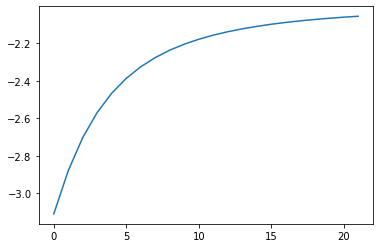

In [14]:
print(f'Convergence achieved at {model_longer.n_iter_} iteration')
_ = plt.plot(model_longer.likelihood)

In [12]:
smae = get_smae(Ximp_longer, X, X_mask)
print(f'The SMAE across 5 exponential variables has: mean {smae[:5].mean():.3f} and std {smae[:5].std():.3f}')
print(f'The SMAE across 5 1-5 oridnal variables has: mean {smae[5:10].mean():.3f} and std {smae[5:10].std():.3f}')
print(f'The SMAE across 5 boolean variables has: mean {smae[10:].mean():.3f} and std {smae[10:].std():.3f}')

copula_corr_est = model_longer.get_params()['copula_corr']
cor_error = get_scaled_error(copula_corr_est, copula_corr)
print(f'The scaled correlation error is: {cor_error:.3f}')

The SMAE across 5 exponential variables has: mean 0.719 and std 0.073
The SMAE across 5 1-5 oridnal variables has: mean 0.725 and std 0.054
The SMAE across 5 boolean variables has: mean 0.655 and std 0.069
The scaled correlation error is: 0.138


Interestingly, the early stopping criterion causes slight underfitting. However, the convergence in late stage is slow and the slight improvement is at the cost of almost twice computation time. Thus whether to use the early stopping criterion should depend on the task. If we just want a pretty good estimator in short time, the default choice `tol=0.001, likelihood_min_increase=0.01` is good to go. If we want to have an estimator that fits the data as well as possible, we could decrease either `tol` (smaller positive) or `likelihood_min_increase` (as low as 0). The particular choice can be tuned using a validation set, but in general the results from the default setting will be very close to a carefully tuned setting. 

Also, it is observed when the computed likelihood values do not monotonically increase, it indicates that the Gaussian copula model is not well suited to the used dataset. Thus we could also use the computed likelihood values as diagnosis for whether the model assumption is satisfied. In next section, we will see an example when the assumption is violated.

### A case study on the influence of variable types specification 

We use eight demographic variables from the 2014 General Social Survey data: age (`AGE`), highest degree (`DEGREE`), income (`RINCOME`), famlily income when 16 years old,general happiness (`INCOM16`),  satisfaction with the work (`SATJOB`), weeks worked last year (`WEEKSWRK`), general happiness (`HAPPY`), condition of health (`HEALTH`). All variables are ordinal variables encoded as integers, although with varying number of ordinal categories. The ordinal categories could be exact numbers such as $0, 1, \cdots, 52$ for `WEEKSWRK`. It could also be ordered categories, for example 1, 2, 3 for the question "how would you say things are these days" (`HAPPY`) correspond to "Very happy", "Pretty happy", "Not too happy".  This dataset comes with many missing values due to anwsers like "Don't know", "No answer", "Not applicable", etc.

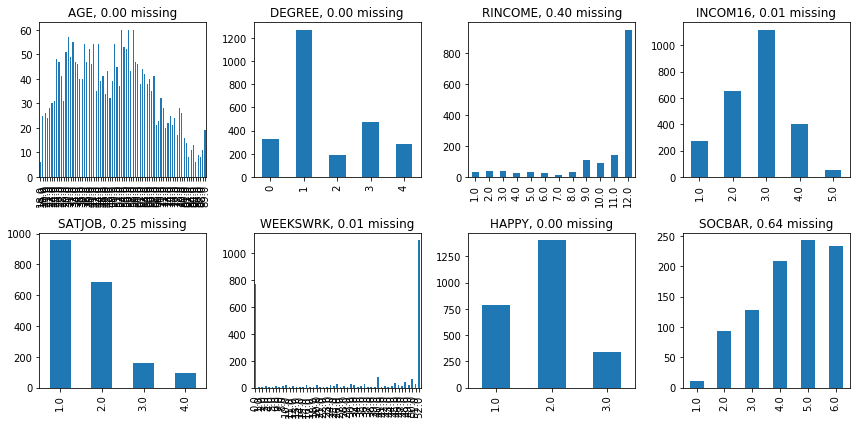

In [47]:
cols = ['AGE', 'DEGREE', 'RINCOME', 'INCOM16', 'SATJOB', 'WEEKSWRK', 'HAPPY', 'SOCBAR']
data_gss = load_GSS(cols = cols)
fig, axes = plt.subplots(2, 4, figsize=(12,6))
for i,col in enumerate(data_gss):
    data_gss[col].dropna().value_counts().sort_index().plot(kind='bar', ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(f'{col}, {data_gss[col].isna().mean():.2f} missing')
plt.tight_layout()

Let us first run the Gaussian copula model on this dataset with the default setting. While both `AGE` and `WEEKSWRK` have many ordinal categories, only `AGE` is treated as a continuous variable, as shown below. 

In [48]:
m_gss = GaussianCopula(verbose=1)
Ximp_gss = m_gss.fit_transform(data_gss)
print(f'Continuous variables: {m_gss.features_names[m_gss.cont_indices]}')

Iteration 1: copula correlation update ratio 0.0795, likelihood -2.5827
Iteration 2: copula correlation update ratio 0.0416, likelihood -2.5106
Iteration 3: copula correlation update ratio 0.0241, likelihood -2.4745
Iteration 4: copula correlation update ratio 0.0149, likelihood -2.4546
Early stop because the likelihood increase is below 0.01
Convergence achieved at iteration 4
Continuous variables: ['AGE']


Recall `GaussianCopula()` looks at the mode occurence frequency to distinguish continuous variables from ordinal: only those variables whose mode occurence frequency is below $0.1$ (in the default setting) are continuous. We could also manually compute those numbers:

In [50]:
data_gss.apply(lambda x: x.dropna().value_counts(normalize=True).max())

AGE         0.023725
DEGREE      0.500000
RINCOME     0.624425
INCOM16     0.446486
SATJOB      0.504485
WEEKSWRK    0.436530
HAPPY       0.554545
SOCBAR      0.264706
dtype: float64

Now it is clear why only `AGE` is treated as continuous. While `WEEKSWRK` has many ordinal categories, it is mostly appearing in two cateories: 0 and 52, and thus has large mode occurence frequency $0.44$. In contrast, the probability mass of `AGE` is more spreaded out and thus it has a much smaller mode occurence frequency $0.02$. But what happens if we insist on setting `WEEKWRK` as an ordinal variable? The answer is that the algorithm may diverge and the likelihood values do not increase during the fitting, as shown below.

In [49]:
m_gss_v2 = GaussianCopula(verbose=1, max_iter=10)
Ximp_gss_v2 = m_gss_v2.fit_transform(data_gss, cont_indices = [0, 5])
print(f'Continuous variables: {m_gss_v2.features_names[m_gss_v2.cont_indices]}')

Iteration 1: copula correlation update ratio 0.0928, likelihood -4.8781
Iteration 2: copula correlation update ratio 0.0567, likelihood -4.9230
Iteration 3: copula correlation update ratio 0.0376, likelihood -4.9886
Iteration 4: copula correlation update ratio 0.0260, likelihood -5.0622
Iteration 5: copula correlation update ratio 0.0187, likelihood -5.1320
Iteration 6: copula correlation update ratio 0.0149, likelihood -5.1898
Iteration 7: copula correlation update ratio 0.0142, likelihood -5.2339
Iteration 8: copula correlation update ratio 0.0158, likelihood -5.2673
Iteration 9: copula correlation update ratio 0.0185, likelihood -5.2951
Iteration 10: copula correlation update ratio 0.0214, likelihood -5.3222
Convergence not achieved at maximum iterations
Continuous variables: ['AGE' 'WEEKSWRK']


We stopped the algorithm after 10 iterations since it already started to diverge. The result is quite surprising that changing a single variable's type can make the whole algorithm diverge. It is a strong notice that we need to specify data types properly. Luckily, the default setting is found to work well. Another thing we can learn here is that the computed likelihood indeed indicates how well the Gaussian copula model fits the data. If we see that the likelihood values do not monotonically increase during the fitting, it is a signal that the Gaussian copula model may not fit the data well, even when the algorithm actually converges. 

## Acceleration through parallelism, minibatch training, and low rank structure

Running `GaussianCopula()` with default setting (`training_mode='standard'`) has computational complexity $O(np^3)$ for each EM iteration. However, we can achieve great amount of acceleration if using it cleverly. 
To speed up the model's execution, three tools are provided: parallelism, minibatch training and low rank structure.

Parallelism is the most straightforward and the easiest acceleration tool to use. By calling `GaussianCopula(n_jobs=k)`, we can distribute the computation across $n$ rows using $k$ cores. It is best suited for datasets with large $n$ and small $p$. 

Minibatch training, invoking by calling `GaussianCopula(training_mode='minibatch-offline')`, also aims to accelerate the model's exceution for large $n$ and small $p$ problem. It randomly shuffles the data and divide them into minibatches, and then perform model updates at each minibatch. The algorithm converges much faster as the model is updated more frequently. It can also be used together with parallelism to distribute the computation across all rows inside a minibatch. Although it requires additional work to choose the learning rates, batch size and a different stopping criterion, we will see the selection is not that difficult shortly.

Low rank structure is developed for large $p$ problem where the $O(np^3)$ computation is unaffordable. The model created by calling `LowRankGaussianCopula(rank=k)` has $O(npk^2)$ complexity per iteration. It also supports parallelism by specifying `n_jobs`, and the computation is distributed over all rows and all columns. Unfortunately, the minibatch training for `LowRankGaussianCopula()` is nontrivial and has not yet been developed. Still, if working with large $n$ and large $p$ dataset, using `LowRankGaussianCopula()` with parallelism should be satisfying.

For the following, we give guidelines on how to use each acceleration tool properly.

### Acceleration for large $n$ problem: minibatch training

For large n problem, the users can use minibatch EM [our online] to conduct more frequent model updates and thus achieve fast convergence. Recall at each EM iteration, the update rule is $\Sigma_{t+1}=(1-\eta_{t+1})\Sigma_t+\eta_{t+1}\hat\Sigma$, where $\Sigma_t$ is the model estiamte at iteration $t$, $\hat \Sigma$ is the new estiamte on the used minibatch and $\eta_t$ is the step size. Thus to use minibatch training, one needs to specify the decaying step size $\{\eta_t\}$, the minibatch size $s$ and the number of iterations $k$ to run. 

On the selection of batch size $s$, the online update rule requires $s\geq p$ to avoid singular matrix operation [our online], although we observe vilation of this requirement does not necessarily break down the algorithm. For the task of accelerating the algorithm, there should be no pain to satisfy $s\geq p$, since if $p$ is too large, the user should use a `LowRankGaussianCopula()` model instead. After fixing the batch size, we recommend to select the maximum number of iterations based on the number of passes desired, i.e. $k=\left \lceil{\frac{n}{s}}\right \rceil  \times n_{\textit{pass}}$. Often we find using $n_{\textit{pass}}=2 \mbox{ or }3$ gives good enough results.

According to [online EM and our online], the decayling step size should satisfy $\sum_{t=1}^\infty \eta_t=\infty$ and $\sum_{t=1}^\infty \eta_t^2<\infty$. To conveniently ensure $\eta_t \in (0, 1)$ for all $t$, we recommend use $\eta_t = c/(c+t)$ with $c>0$. Roughly speaking, the model receives $50\%$ udpate at $c$-th iteration and $5\%$ update at $19c$-th iteration, when $c$ is an integer. We recommend to tune $c$ in the range $(0, 10)$, but a value of $5$ works well in many settings we experimented. 

To use the default setting of step size $\eta_t=5/(t+5)$, minibatch size $s=100$ and the maximum number of iterations $k=\left \lceil{\frac{n}{s}}\right \rceil  \times 2$, simple run the following:

In [3]:
model_minibatch = GaussianCopula(training_mode='minibatch-offline', verbose=1)
Ximp = model_minibatch.fit_transform(X=X_mask)

The number of maximum iteration is set as 40 to have 2 passes over all data
Iteration 1: copula correlation update ratio 0.177, likelihood -3.110
Iteration 2: copula correlation update ratio 0.133, likelihood -3.060
Iteration 3: copula correlation update ratio 0.147, likelihood -3.191
Iteration 4: copula correlation update ratio 0.143, likelihood -2.813
Iteration 5: copula correlation update ratio 0.093, likelihood -2.487
Iteration 6: copula correlation update ratio 0.100, likelihood -2.990
Iteration 7: copula correlation update ratio 0.066, likelihood -2.383
Iteration 8: copula correlation update ratio 0.068, likelihood -2.487
Iteration 9: copula correlation update ratio 0.054, likelihood -2.409
Iteration 10: copula correlation update ratio 0.051, likelihood -2.559
Iteration 11: copula correlation update ratio 0.051, likelihood -2.518
Iteration 12: copula correlation update ratio 0.051, likelihood -2.450
Iteration 13: copula correlation update ratio 0.052, likelihood -2.750
Iteration 

In [5]:
smae = get_smae(Ximp, X, X_mask)
print(f'The SMAE across 5 exponential variables has: mean {smae[:5].mean():.3f} and std {smae[:5].std():.3f}')
print(f'The SMAE across 5 1-5 oridnal variables has: mean {smae[5:10].mean():.3f} and std {smae[5:10].std():.3f}')
print(f'The SMAE across 5 boolean variables has: mean {smae[10:].mean():.3f} and std {smae[10:].std():.3f}')

copula_corr_est = model_minibatch.get_params()['copula_corr']
cor_error = get_scaled_error(copula_corr_est, copula_corr)
print(f'The scaled correlation error is: {cor_error:.3f}')

The SMAE across 5 exponential variables has: mean 0.740 and std 0.049
The SMAE across 5 1-5 oridnal variables has: mean 0.823 and std 0.125
The SMAE across 5 boolean variables has: mean 0.589 and std 0.045
The scaled correlation error is: 0.156


The user could also supply their own choice of step size, minibatch size and the maximum number of iterations, as the following example.

In [9]:
model_minibatch = GaussianCopula(training_mode='minibatch-offline', 
                                 stepsize_func = lambda t, c=5:c/(c+t),
                                 batch_size = 100,
                                 num_pass = 3,
                                 verbose = 1
                                )
Ximp = model_minibatch.fit_transform(X=X_mask)

The number of maximum iteration is set as 60 to have 3 passes over all data
Iteration 1: copula correlation update ratio 0.177, likelihood -3.110
Iteration 2: copula correlation update ratio 0.133, likelihood -3.060
Iteration 3: copula correlation update ratio 0.147, likelihood -3.191
Iteration 4: copula correlation update ratio 0.143, likelihood -2.813
Iteration 5: copula correlation update ratio 0.093, likelihood -2.487
Iteration 6: copula correlation update ratio 0.100, likelihood -2.990
Iteration 7: copula correlation update ratio 0.066, likelihood -2.383
Iteration 8: copula correlation update ratio 0.068, likelihood -2.487
Iteration 9: copula correlation update ratio 0.054, likelihood -2.409
Iteration 10: copula correlation update ratio 0.051, likelihood -2.559
Iteration 11: copula correlation update ratio 0.051, likelihood -2.518
Iteration 12: copula correlation update ratio 0.051, likelihood -2.450
Iteration 13: copula correlation update ratio 0.052, likelihood -2.750
Iteration 

In [10]:
smae = get_smae(Ximp, X, X_mask)
print(f'The SMAE across 5 exponential variables has: mean {smae[:5].mean():.3f} and std {smae[:5].std():.3f}')
print(f'The SMAE across 5 1-5 oridnal variables has: mean {smae[5:10].mean():.3f} and std {smae[5:10].std():.3f}')
print(f'The SMAE across 5 boolean variables has: mean {smae[10:].mean():.3f} and std {smae[10:].std():.3f}')

copula_corr_est = model_minibatch.get_params()['copula_corr']
cor_error = get_scaled_error(copula_corr_est, copula_corr)
print(f'The scaled correlation error is: {cor_error:.3f}')

The SMAE across 5 exponential variables has: mean 0.737 and std 0.048
The SMAE across 5 1-5 oridnal variables has: mean 0.816 and std 0.124
The SMAE across 5 boolean variables has: mean 0.590 and std 0.048
The scaled correlation error is: 0.150


On this simulated dataset, the minibatch training mode with 2 passes has achieved very close results compared to the standard training mode using only $24\%$ runtime. Increasing the number of passes to 3 brings slight improvement in model parameter estimation accuracy and imputaiton accuracy on the continuous and ordinal variables. The particular choice of the number of passes can be decided based on the user's preference on the tradeoff between runtime and accuracy.

In [ ]:
m1 = GaussianCopula()
m2 = GaussianCopula(training_mode='minibatch-offline', num_pass = 2)
m3 = GaussianCopula(training_mode='minibatch-offline', num_pass = 3)
t0 = time.time()
_ = m1.fit_transform(X=X_mask)
t1 = time.time()
_ = m2.fit_transform(X=X_mask)
t2 = time.time()
_ = m3.fit_transform(X=X_mask)
t3 = time.time()

In [14]:
print(f'Standard mode takes {t1-t0:.1f}s, while minibatch mode takes {t2-t1:.1f} with 2 passes and {t3-t2:.1f} with 3 passes')

Standard mode takes 59.0s, while minibatch mode takes 14.0 with 2 passes and 21.4 with 3 passes


### Acceleration for large $p$ problem: low rank structure

In [15]:
seed = 101
var_types = {'cont':list(range(100)), 'ord':list(range(100, 150, 1)), 'bin':list(range(150, 200, 1))}
Xtrue, Wtrue = generate_LRGC(var_types=var_types, 
                             rank=10, 
                             sigma=0.1, 
                             n=2000, 
                             cont_transform=lambda x: np.power(x,3),
                             seed=seed)

In [16]:
np.random.seed(seed)
X_masked = mask(Xtrue, mask_fraction = 0.4, seed=seed)

In [17]:
model_lrgc = LowRankGaussianCopula(rank=10, verbose=1)

In [18]:
Ximp = model_lrgc.fit_transform(X=X_masked)

Ater initialization, W has shape (200, 10) and sigma is 0.21016169823236375
Interation 1: noise ratio estimate 0.136, copula parameter update ratio 0.063, likelihood 126.387
Interation 2: noise ratio estimate 0.114, copula parameter update ratio 0.017, likelihood 172.965
Interation 3: noise ratio estimate 0.106, copula parameter update ratio 0.008, likelihood 190.359
Interation 4: noise ratio estimate 0.103, copula parameter update ratio 0.005, likelihood 197.334
Interation 5: noise ratio estimate 0.102, copula parameter update ratio 0.004, likelihood 200.288
early stop because changed likelihood below 1%


In [19]:
smae = get_smae(Ximp, Xtrue, X_masked)

print(f'The SMAE across 5 exponential variables has: mean {smae[:100].mean():.3f} and std {smae[:100].std():.3f}')
print(f'The SMAE across 5 1-5 oridnal variables has: mean {smae[100:150].mean():.3f} and std {smae[100:150].std():.3f}')
print(f'The SMAE across 5 boolean variables has: mean {smae[150:].mean():.3f} and std {smae[150:].std():.3f}')

The SMAE across 5 exponential variables has: mean 0.500 and std 0.024
The SMAE across 5 1-5 oridnal variables has: mean 0.365 and std 0.036
The SMAE across 5 boolean variables has: mean 0.262 and std 0.033


In [20]:
copula_factor_loading = model_lrgc.get_params()['copula_factor_loading']
cor_error = grassman_dist(copula_factor_loading, Wtrue)
print(f'The latent subspace estimation error is: {cor_error[0]:.3f}')

The latent subspace estimation error is: 0.159


### Acceleration for all tasks: parallelism

## Online tasks

In [9]:
model_online = GaussianCopula(training_mode='minibatch-online', cont_indices=[True]*5+[False]*10)
Ximp = model_online.fit_transform(X=X_mask)

In [10]:
smae = get_smae(Ximp, X, X_mask)

print(f'The SMAE across 5 exponential variables has: mean {smae[:5].mean():.3f} and std {smae[:5].std():.3f}')
print(f'The SMAE across 5 1-5 oridnal variables has: mean {smae[5:10].mean():.3f} and std {smae[5:10].std():.3f}')
print(f'The SMAE across 5 boolean variables has: mean {smae[10:].mean():.3f} and std {smae[10:].std():.3f}')

The SMAE across 5 exponential variables has: mean 0.821 and std 0.034
The SMAE across 5 1-5 oridnal variables has: mean 0.908 and std 0.067
The SMAE across 5 boolean variables has: mean 0.665 and std 0.033


In [11]:
copula_corr_est = model_online.get_params()['copula_corr']

cor_error = get_scaled_error(copula_corr_est, copula_corr)
print(f'The scaled correlation error is: {cor_error:.3f}')

The scaled correlation error is: 0.192


In [12]:
model_online_decay = GaussianCopula(training_mode='minibatch-online', 
                                    cont_indices=[True]*5+[False]*10, 
                                    const_stepsize=None, 
                                    verbose = 1)
Ximp = model_online_decay.fit_transform(X=X_mask)

In [13]:
smae = get_smae(Ximp, X, X_mask)

print(f'The SMAE across 5 exponential variables has: mean {smae[:5].mean():.3f} and std {smae[:5].std():.3f}')
print(f'The SMAE across 5 1-5 oridnal variables has: mean {smae[5:10].mean():.3f} and std {smae[5:10].std():.3f}')
print(f'The SMAE across 5 boolean variables has: mean {smae[10:].mean():.3f} and std {smae[10:].std():.3f}')

The SMAE across 5 exponential variables has: mean 0.817 and std 0.037
The SMAE across 5 1-5 oridnal variables has: mean 0.896 and std 0.074
The SMAE across 5 boolean variables has: mean 0.657 and std 0.042


In [14]:
copula_corr_est = model_online_decay.get_params()['copula_corr']

cor_error = get_scaled_error(copula_corr_est, copula_corr)
print(f'The scaled correlation error is: {cor_error:.3f}')

The scaled correlation error is: 0.196
